In [2]:
# netowrks
import networkx as nx
import igraph as ig

# data processing
import pandas as pd
import numpy as np
import scipy.sparse as ss

#some functions to make our lifes easier
import sys
sys.path.append("./")
from common_functions import *

# viz
import pylab as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

#Change the default options of visualization (improving the defaults)
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "axes.spines.bottom":
False,"lines.linewidth": 2, "grid.color": "lightgray", "legend.frameon": False, "xtick.labelcolor": "#484848", "ytick.labelcolor":
"#484848", "xtick.color": "#484848", "ytick.color": "#484848","text.color": "#484848", "axes.labelcolor": "#484848",
"axes.titlecolor":"#484848","figure.figsize": [5,3],
"axes.titlelocation":"left","xaxis.labellocation":"left","yaxis.labellocation":"bottom"}
palette = ["#3d348b","#e6af2e","#191716","#e0e2db"] #use your favourite colours
sns.set_theme(context='paper', style='white', palette=palette, font='Verdana', font_scale=1.3, color_codes=True,
rc=custom_params)

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
path_data = "../Data/"

In [4]:
def plot_network(G, a0 = None, values = None):
    """
    Plots network with nice defaults
    """
    if values is None:
        values = nx.degree_centrality(G).values()
    
    norm = mpl.colors.Normalize(vmin=min(values), vmax=max(values), clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
    mapper._A = []
    cb = plt.colorbar(mapper, ax = a0, location="bottom", shrink=0.8, pad = 0.02, label = "Value")
    cb.outline.set_visible(False)

    # NEtwork
    if nx.is_bipartite(G):
        top = [_ for _ in G.nodes() if _[0] != "S"]
        pos = nx.bipartite_layout(G, top)
        node_color = ["#e6af2e" if node in top else "#e0e2db" for node in G]
    else:
        pos = nx.spring_layout(G, seed = 1)
        node_color = [mapper.to_rgba(i) for i in values]

    nx.draw(G, pos = pos, with_labels = True, node_size=500*np.array(list(values)), edge_color = "darkgray", 
           node_color = node_color, ax = a0)
    
    
def plot_network_adj(G, values = None):
    """
    Plots the graph (with color/node size adjusted according to values) and the adjacency matrix
    """
    f, (a0, a1, a2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 0.5]}, figsize=(12,4))
    
    # Plot network
    plot_network(G, a0, values = values)
    
    # Show adjacency table
    df = nx.to_pandas_adjacency(G, nodelist=list(G.nodes()), dtype=int)
    plot_table(a1, df.values, df.index, df.columns)

    A = nx.to_scipy_sparse_array(G, nodelist=list(G.nodes()), weight=1)
    N = len(G.nodes())
    
    # Plot table as a heatmap
    a2.spy(A)
    sns.despine(bottom="True", left=True)
    plt.grid(True)
    a2.set_xticks(range(N), G.nodes(), rotation=90)
    a2.set_yticks(range(N), G.nodes())
    
    plt.tight_layout()

def plot_table(a1, cellText, rowLabels, colLabels):
    """
    Plots a table in a figure
    """
    cellText = pd.DataFrame(cellText)
    the_table = a1.table(cellText=cellText.values, rowLabels=rowLabels, colLabels=colLabels, loc='center', colLoc = "left", cellColours=(cellText>0).replace({False: "white", True:"#e6af2e"}).values)
    a1.axis(False) 
    the_table.scale(0.8, 1.6)

    
def adj_to_net(A, d_names = {0: "Alice", 1: "Bob", 2: "John", 3:"Amy", 4:"Mike", 5:"Rose"}):
    """
    Create graph from adjacency matrix, rename nodes
    """
    G = nx.from_numpy_array(A, create_using=nx.DiGraph())
    G = nx.relabel_nodes(G, d_names)
    return G



# Let's start by example networks and visualize them
- Note the `create_using` parameter. What is it doing?

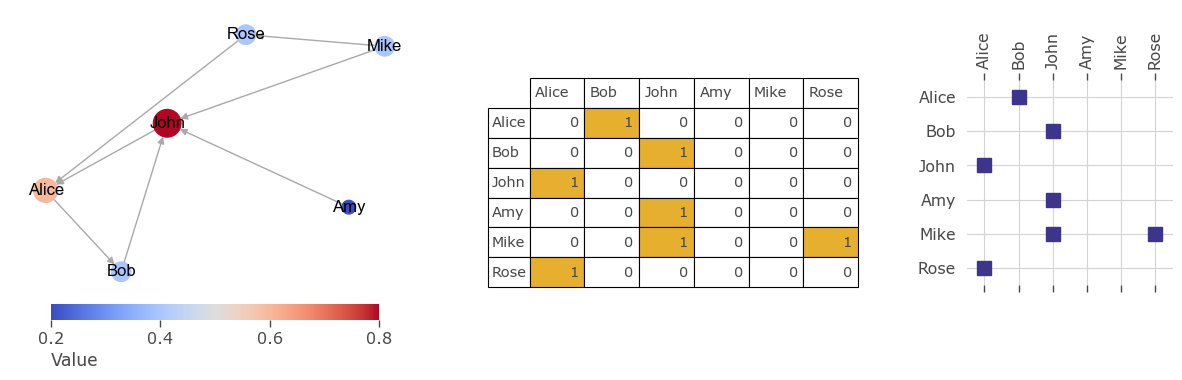

In [5]:
# Small directed network to understand matrix multiplication
G_dir = nx.from_edgelist([
    ("Alice", "Bob"),
    ("John", "Alice"),
    ("Bob", "John"),
    ("Amy", "John"),
    ("Mike", "John"),
    ("Rose", "Alice"),
    ("Mike", "Rose")
], create_using=nx.DiGraph())

plot_network_adj(G_dir)



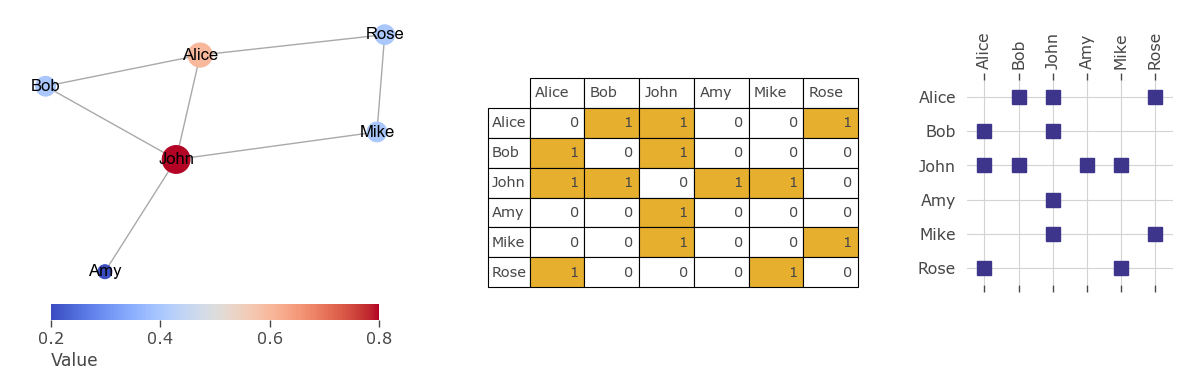

In [6]:
# Small undirected network
G_undir = nx.from_edgelist([
    ("Alice", "Bob"),
    ("John", "Alice"),
    ("Bob", "John"),
    ("Amy", "John"),
    ("Mike", "John"),
    ("Rose", "Alice"),
    ("Mike", "Rose")
], create_using=nx.Graph())


plot_network_adj(G_undir)

In [7]:
# Create some metadata (number of children)
df = pd.DataFrame([["Alice",2],
                  ["Bob",0],
                  ["John",2],
                  ["Amy",0],
                  ["Mike",1],
                  ["Rose",5]], columns=["person","children"])

df

,person,children
0,Alice,2
1,Bob,0
2,John,2
3,Amy,0
4,Mike,1
5,Rose,5


# Exercise 1
__Goal__: Compare different ways to represent matrixes and convert between them 

Start from the `G_dir` network

## 1.1 Convert the directed network  to different formats
- numpy_array
- scipy_sparse_array
- pandas_adjacency
- pandas_edgelist

What are the advantages of each?


In [8]:
#Example: 
A = nx.to_scipy_sparse_array(G_dir, nodelist=list(G_dir.nodes()), weight=1)
A

<6x6 sparse array of type '<class 'numpy.intc'>'
	with 7 stored elements in Compressed Sparse Row format>

### 1.2 Use plt.spy() to visualize the scipy_sparse_array

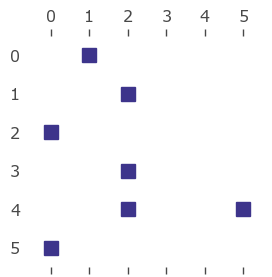

In [9]:
plt.spy(A)

## 1.3 Create a network object from the pandas adjacency list (edgelist)

Now starting from an edgelist (created below, `df_edg`), convert it to a graph. You have done this before in the morning

In [10]:
# Starting from an edgelist
df_edg = nx.to_pandas_edgelist(G_dir, nodelist=list(G_dir.nodes()))
df_edg.head()

,source,target
0,Alice,Bob
1,Bob,John
2,John,Alice
3,Amy,John
4,Mike,John


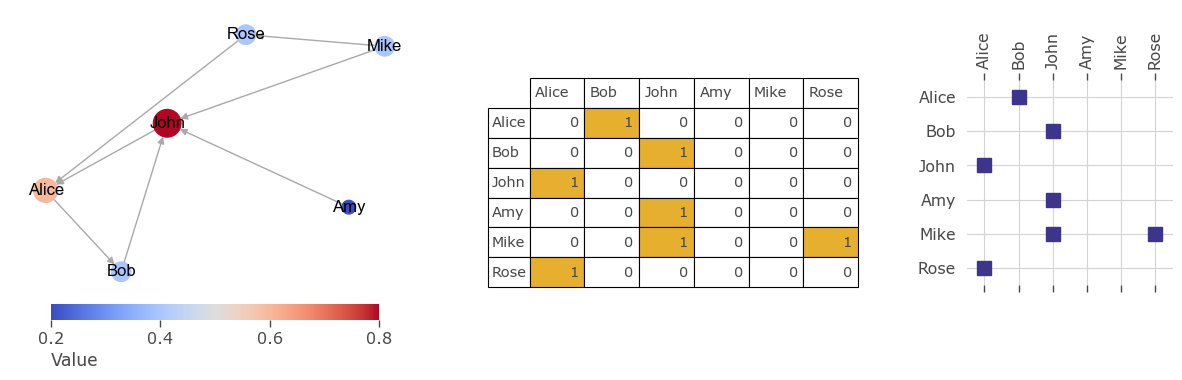

In [12]:
# Convert to graph and plot
G = nx.from_pandas_edgelist(df_edg, create_using=nx.DiGraph())

plot_network_adj(G)

## 1.4 Create a network object from a  adjacency matrix

Now starting from an adjacency matrix (created below, `A`), convert it to a graph. 

In [13]:
# Convert the following adjacency matrix
A = nx.to_scipy_sparse_array(G_dir, nodelist=list(G_dir.nodes()), weight=1)

# Translation between index and names
d_names = {0: 'Alice', 1: 'Bob', 2: 'John', 3: 'Amy', 4: 'Mike', 5: 'Rose'}
A.todense()

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0]], dtype=int32)

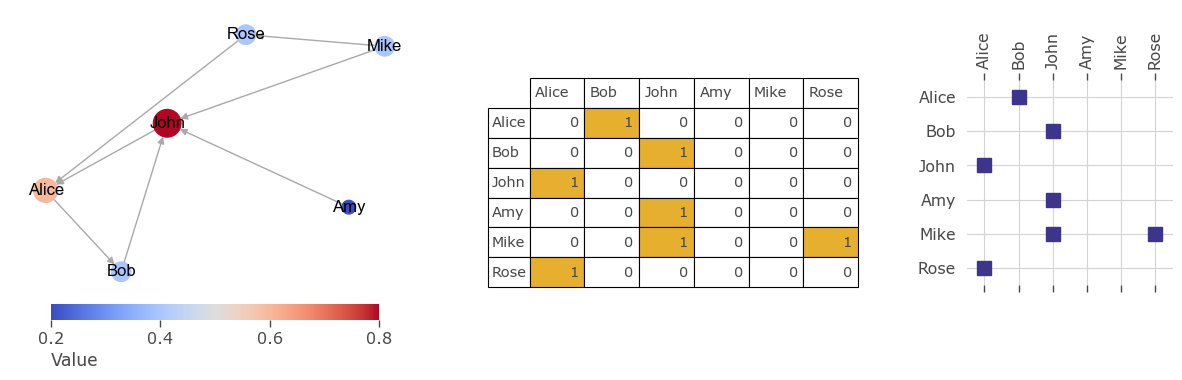

In [14]:
# Convert to graph
G = nx.from_scipy_sparse_array(A, create_using=nx.DiGraph())
# Add labels
G = nx.relabel_nodes(G, d_names) 
# Plot
plot_network_adj(G)

# Exercise 2
What is the average number of children of your friends?

In python
* Matrix multiplication (dot-product) is done using "@" (e.g. A @ B)
    * The number of columns of A needs to match the number of rows of B!
* Element-wise multiplication is done using "*" (e.g. A*B multiplies the element i,j of A with the element i,j of B)
    * If B is an array, the dimensions need to match those of A
    * If B is a vector, it multiplies it row-wise (the number of rows of A need to match the number of elements of B)

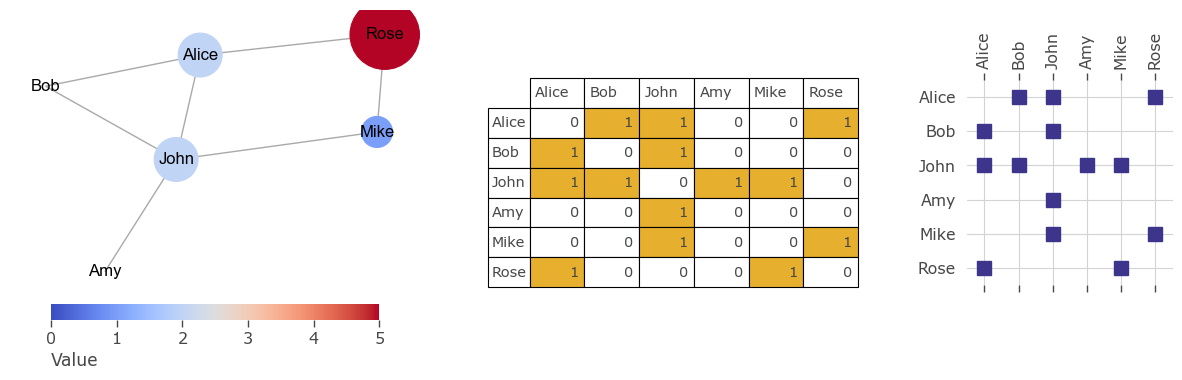

In [15]:
# Original network adding the children as a color/size
plot_network_adj(G_undir, values = df["children"])

[7 4 3 2 7 3]


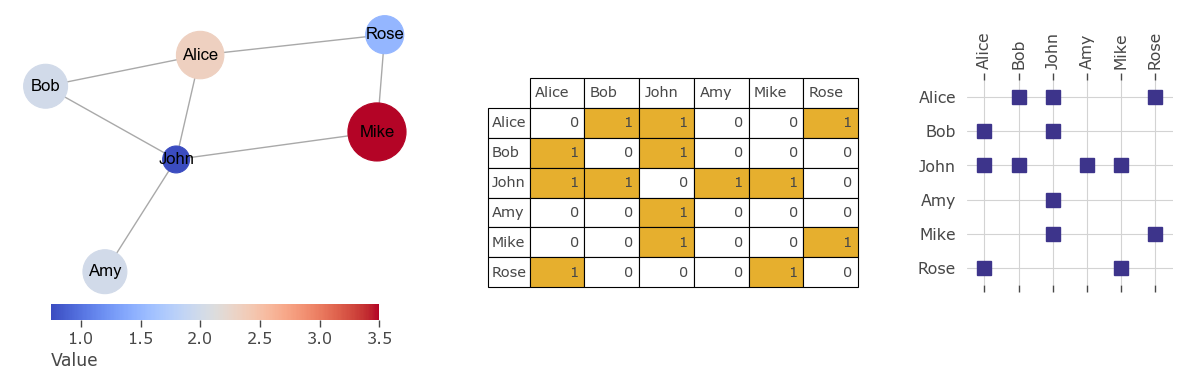

In [32]:
# adjacency array
A = nx.to_scipy_sparse_array(G_undir)

# Calculate sum of neighbors children
sum_children = A @ df["children"]

# Divide by number of neighbors to get an average
avg_children = sum_children / A.sum(axis=1)

print(sum_children)
plot_network_adj(G_undir, values=avg_children)

# Exercise 3: Matrix multiplication
3a. Interpretation as number of routes
- Number of nodes 2 steps away
- Number of nodes 3 steps away
- Number of triangles directed
- Number of triangles undirected

3b. Number of triangles and clustering

## Exercise 3a: Matrix multiplication and paths

One step away
Two steps away
Three steps away. Triangles!


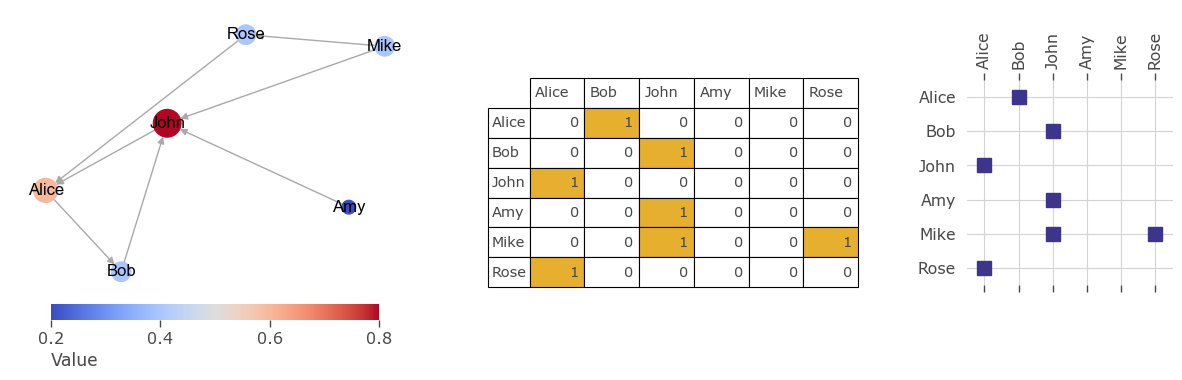

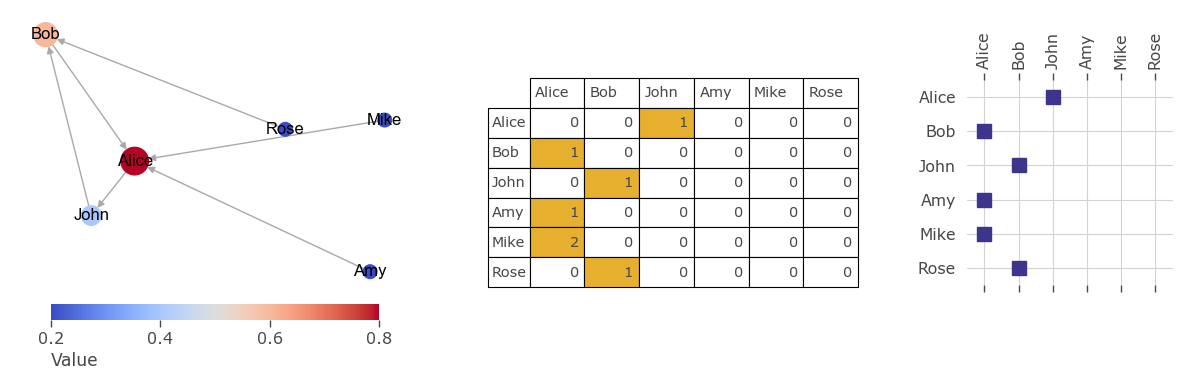

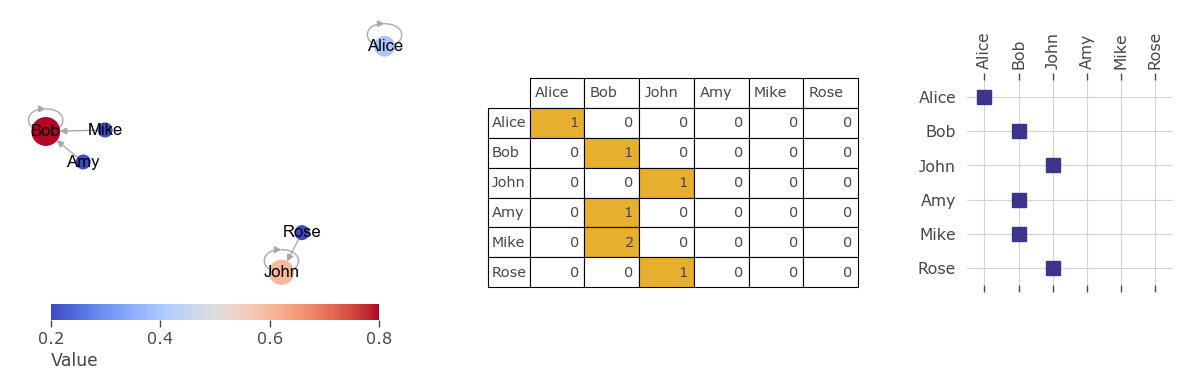

In [34]:
# Number of paths to go from node i to node j in x steps

#x = 1
print("One step away")
plot_network_adj(G_dir)
A = nx.to_scipy_sparse_array(G_dir)

#x = 2
print("Two steps away")
G2 = adj_to_net(A @ A) #A**2
plot_network_adj(G2)

#x = 3
print("Three steps away. Triangles!")
G3 = adj_to_net(A @ A @ A) #A**3
plot_network_adj(G3)



In [40]:
# Number of nodes reached in 3 steps
M = (A + A**2 + A**3) > 0 
M.setdiag(0) # do not count yourself
M.todense().sum(1)

#display(M.todense())

#print total (sum per row)
M.todense().sum(1)

c:\Users\megan\anaconda3\envs\environment\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


array([1, 1, 1, 1, 2, 1])

In [41]:
display((A @ A).todense())
display(A.todense())

array([[0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=int32)

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0]], dtype=int32)

## Exercise 3b: Number of triangles and clustering

AttributeError: 'ellipsis' object has no attribute 'diagonal'

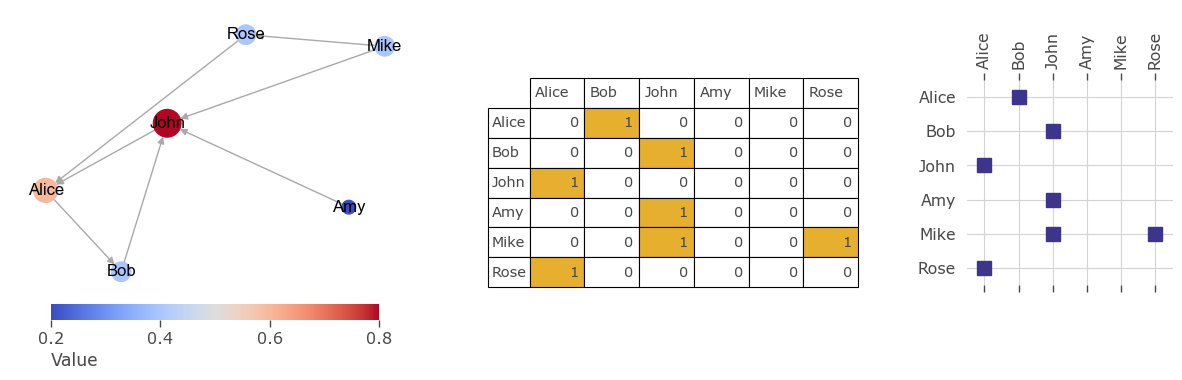

In [42]:
# Count number of triangles in the directed network (se A^3)
plot_network_adj(G_dir)
A = nx.to_scipy_sparse_array(G_dir)
path_3 = ...

# For undirected newtorks there are two directions, for directed networks one
display(list(zip(G_dir.nodes(), path_3.diagonal() )))

# Number of triangles = trace / 3 (each  triangle count in 3 nodes)
print(...)

[('Alice', 1.0),
 ('Bob', 1.0),
 ('John', 1.0),
 ('Amy', 0.0),
 ('Mike', 0.0),
 ('Rose', 0.0)]

1.0


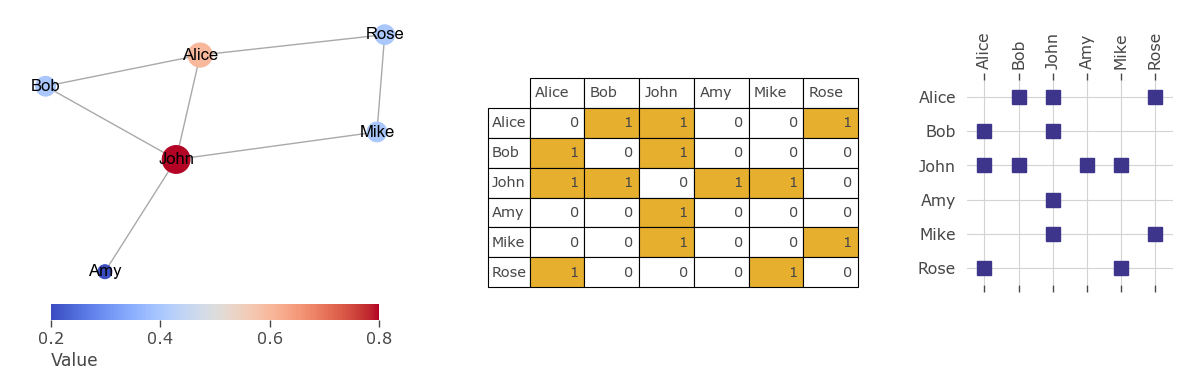

In [19]:
# Count number of triangles in the undirected network
plot_network_adj(G_undir)
A = nx.to_scipy_sparse_array(G_undir)
path_3 = ...


# For undirected newtorks there are two directions
display(list(zip(G_undir.nodes(), path_3.diagonal() / 2)))

# Number of triangles = trace / 6 (each  triangle count in 3 nodes, each triangle counted in two directions)
print(...)

In [21]:
#Local clustering = number of triangles / number of potential links
print(nx.clustering(G_undir)) #standard nx function

# Number of triangles
path_3 = (A@A@A).diagonal()/2 # divided by two because there are two directions

# Number of potential links between neighbors
#(if you have 3 neighbors, there are 3*2/2 potential triangles. /2 since it's an undirected network)
degree = A.sum(1)
potential_links = ...

list(zip(G_undir.nodes(), path_3, potential_links, path_3/potential_links))

{'Alice': 0.3333333333333333, 'Bob': 1.0, 'John': 0.16666666666666666, 'Amy': 0, 'Mike': 0, 'Rose': 0}


/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_81311/980830522.py:11: RuntimeWarning: invalid value encountered in true_divide
  list(zip(G_undir.nodes(), path_3, potential_links, path_3/potential_links))


[('Alice', 1.0, 3.0, 0.3333333333333333),
 ('Bob', 1.0, 1.0, 1.0),
 ('John', 1.0, 6.0, 0.16666666666666666),
 ('Amy', 0.0, 0.0, nan),
 ('Mike', 0.0, 1.0, 0.0),
 ('Rose', 0.0, 1.0, 0.0)]

---

# Exercise 4 Calculate node centrality
- Degree 
- Closeness
- Harmonic
- Betweeness 
- Eigenvector
- Pagerank
- Katz
- HITS


Display using the function `plot_network_distribution`, so the centrality gets displayed as color.

In [43]:
G = nx.florentine_families_graph()

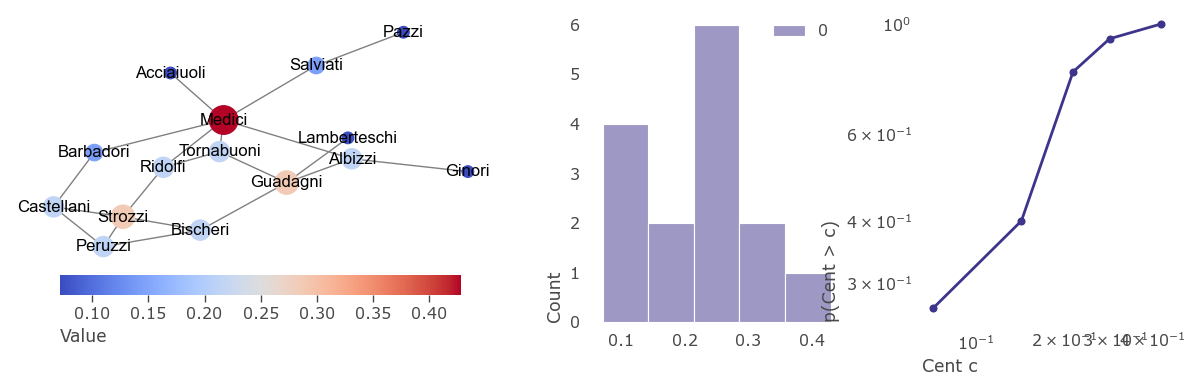

In [44]:
# Degree centrality
cent = nx.degree_centrality(G) 
cent = cent.values()

plot_network_distribution(G, cent)

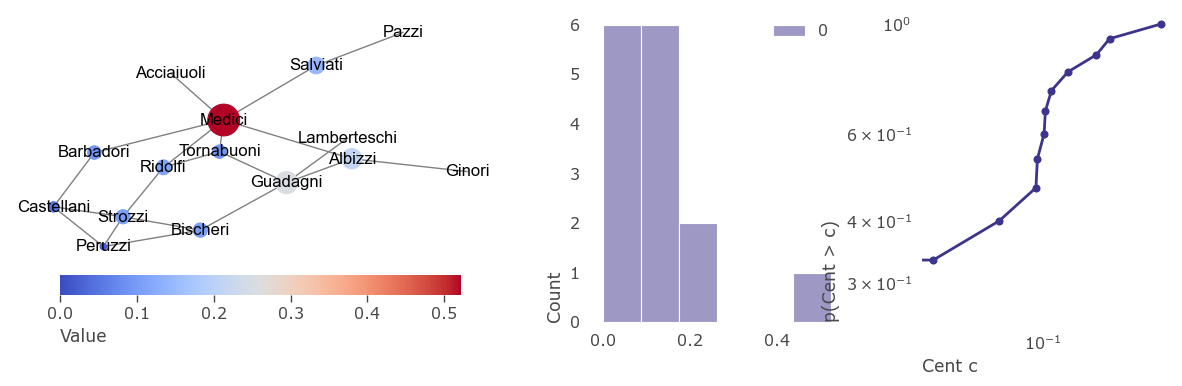

In [45]:
# Betweeness centrality
cent = nx.betweenness_centrality(G) 
cent = cent.values()

plot_network_distribution(G, cent)

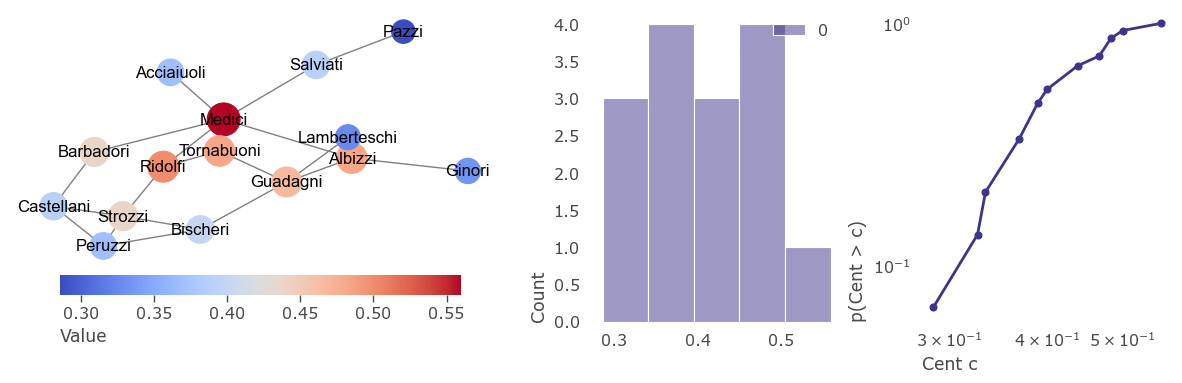

In [46]:
# Closeness centrality
cent = nx.closeness_centrality(G) 
cent = cent.values()

plot_network_distribution(G, cent)

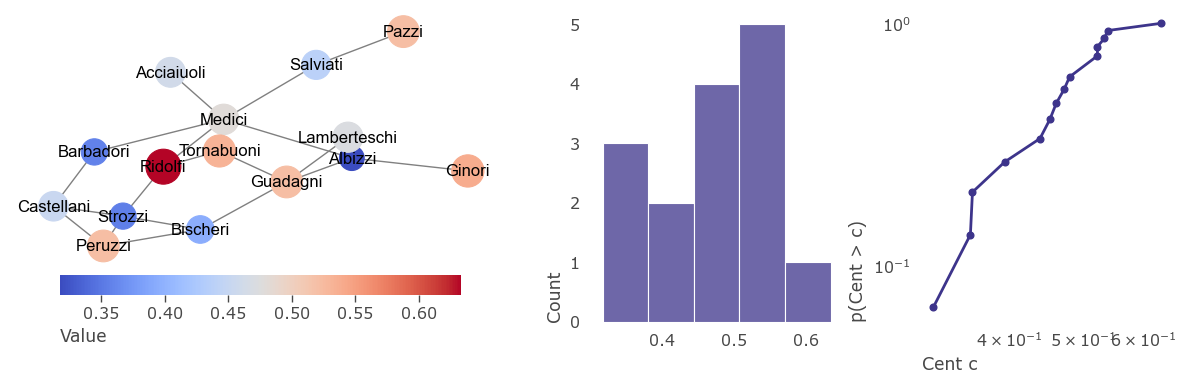

In [47]:
# Harmonic centrality
cent = nx.harmonic_centrality(G) 
cent = np.array(list(cent.values()))/15

plot_network_distribution(G, cent)

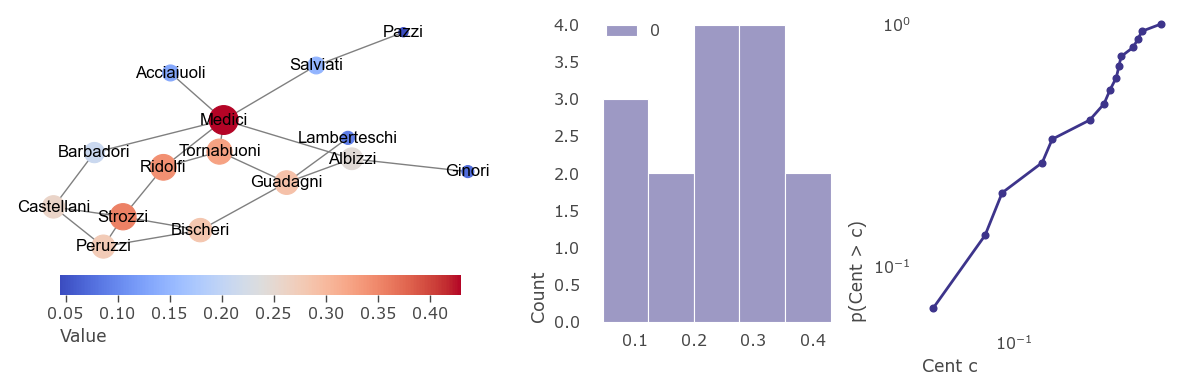

In [48]:
# Eigenvector centrality
cent = nx.eigenvector_centrality(G)
cent = cent.values()

plot_network_distribution(G, cent)

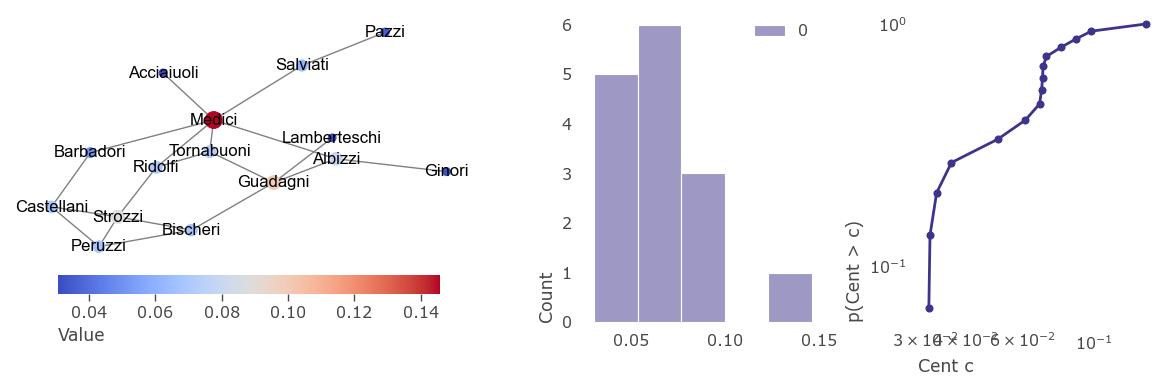

In [52]:
# Pagerank centrality
cent = nx.pagerank(G) 
cent = cent.values()

plot_network_distribution(G, cent)

In [ ]:

#- Katz
#- HITS

# Exercise 5
Using the Twitter dataset
- If you would have to spread some super important news (it always gets shared) as quickly as possible, which nodes would you choose?
- If you would want to make the network disconnected, which nodes would you remove?
- If you would want to understand which node is most respected (measured by mentions) in the network, which nodes would you choose?
- If you would have to spread some fake news (it gets shared sometimes but not alwasy), which nodes would you choose?

Find the top 10 nodes for each measure

In [53]:
# Read edgelist
df = pd.read_csv(f"{path_data}/ic2s2_netsci_3.tsv", sep="\t")

# Convert to networkx
Gt = nx.from_pandas_edgelist(df)
Gt.remove_edges_from(nx.selfloop_edges(Gt)) #remove self-edges


In [54]:
def extract_top_10(d_centrality):
    return pd.DataFrame.from_dict(d_centrality, orient="index").sort_values(by=0, ascending=False).head(10)

#e.g. extract_top_10(nx.degree_centrality(Gt))

In [55]:
cc = extract_top_10(nx.closeness_centrality(Gt)) #slow (all distances)
bc = extract_top_10(nx.betweenness_centrality(Gt)) #slow (all shortest paths)
ac = extract_top_10(nx.hits(Gt)[1]) #in theory for directed networks 
ec = extract_top_10(nx.eigenvector_centrality(Gt))

df = pd.concat([cc,bc,ac,ec], axis=1)
df.columns = ["closeness","betweeness","authorities","eigenvalue"]
df

,closeness,betweeness,authorities,eigenvalue
manlius84,0.554247,0.030209,0.005851,0.137013
svscarpino,0.544530,0.021886,0.005404,0.126543
tiagopeixoto,0.543768,0.019763,0.005269,0.123383
alexvespi,0.541681,0.022093,0.004963,0.116209
HirokiSayama,0.540362,NaN,0.005388,0.126154
barabasi,0.536257,0.022566,NaN,NaN
tinaeliassi,0.532214,NaN,NaN,NaN
fede7j,0.531485,NaN,0.005046,0.118155
lordgrilo,0.531303,0.018196,0.005073,0.118777
cosnet_bifi,0.530396,NaN,0.004977,0.116525


# Exercise 6: Eigenvector (even more advanced)

Let's calculate eigenvector and pagerank centrality using the power method



## 6.1 Eigenvector

For eigenvector centrality, each node has an influence of 1, that it is distributed to the neighbors. This process is done many times, until it converges.

['Alice', 'Bob', 'John', 'Amy', 'Mike', 'Rose']
[0.48666426 0.32444284 0.64888568 0.16222142 0.32444284 0.32444284]


/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_81311/2527873051.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(mapper, ax = a0, location="bottom", shrink=0.8, pad = 0.02, label = "Value")


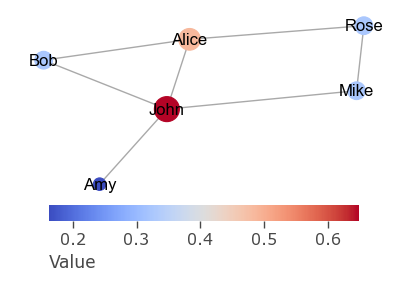

['Alice', 'Bob', 'John', 'Amy', 'Mike', 'Rose']
[0.50196464 0.43921906 0.50196464 0.25098232 0.37647348 0.3137279 ]


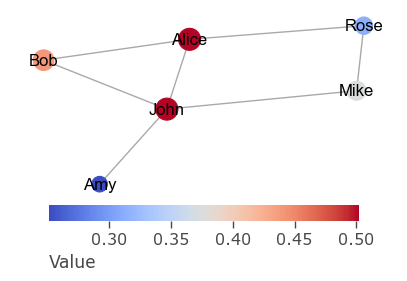

['Alice', 'Bob', 'John', 'Amy', 'Mike', 'Rose']
[0.48365083 0.38692067 0.60456354 0.19346033 0.31437304 0.33855558]


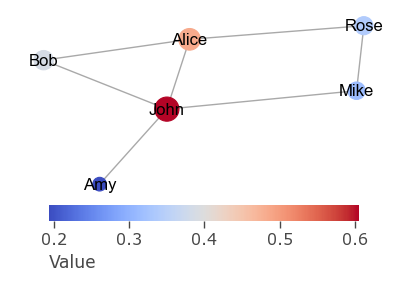

['Alice', 'Bob', 'John', 'Amy', 'Mike', 'Rose']
[0.51212115 0.41900822 0.53074374 0.23278234 0.36314046 0.30727269]


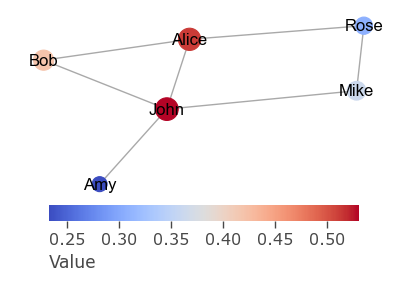

['Alice', 'Bob', 'John', 'Amy', 'Mike', 'Rose']
[0.483843   0.40141049 0.58777964 0.20428927 0.322562   0.33689809]


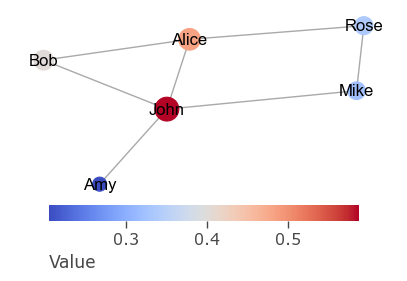

[('Alice', 0.49816568565363206), ('Bob', 0.40845488054415907), ('John', 0.5634381194270055), ('Amy', 0.21678431148030036), ('Mike', 0.3410115867353848), ('Rose', 0.3228756816201712)]


{'Alice': 0.49816562620567956,
 'Bob': 0.4084543148167931,
 'John': 0.563437771403002,
 'Amy': 0.21678389847563684,
 'Mike': 0.3410123357350908,
 'Rose': 0.32287658256564244}

In [32]:
# Eigenvector centrality, manually
N = len(G_dir)
A = nx.to_numpy_array(G_undir)

# Start with everybody having 1 unit of influence
weight = np.ones(N)
for i in range(100):
    # spread influence to neighbors 
    weight = weight @ A

    # normalize uwing the geometrical mean
    weight = weight / np.sqrt(np.sum(weight**2))
    
    if i < 5:
        print(G_undir.nodes())
        print(weight)

        plot_network(G_undir, None, values = weight)
        plt.show()

# Compare with the results of networkx
print(list(zip(G_undir.nodes(), weight)))
nx.eigenvector_centrality(G_undir)

## 6.2 Pagerank
For pagerank centrality, we start with 1 random walker distributed over all nodes, from there, it gets distributed to the neighbors (1/k of the random walker go to each of the k neighbors). This process is done many times, until it converges.

In [33]:
# PAgerank centrality, manually
N = len(G_dir)
A = nx.to_numpy_array(G_dir)

## Calculate transition matrix (Row normalize matrix)
# construct diagonal inverse degree matrix
degree = A.sum(1)
D = np.diag(1./degree, 0)
A_hat = (D @ A)

# random walkers are spread out evenly
weight = np.ones(N)/N

for i in range(1000):
    # calculate where random walkers go next
    weight = weight @ (0.85*A_hat + 0.15/N)

# Compare results with networkx
print(list(zip(G_dir.nodes(), weight)))
nx.pagerank(G_dir)

[('Alice', 0.31535471331389314), ('Bob', 0.2930515063168089), ('John', 0.3059687803692869), ('Amy', 0.024999999999999696), ('Mike', 0.024999999999999696), ('Rose', 0.03562499999999957)]


{'Alice': 0.3153534818017285,
 'Bob': 0.293052806246324,
 'John': 0.3059687119519481,
 'Amy': 0.025,
 'Mike': 0.025,
 'Rose': 0.035625000000000004}

## 6.3 Infinite random walker

A random walker ends up a fraction of time in each node proportional to the degree of the node

In [34]:

N = len(G_undir)
A = nx.to_numpy_array(G_undir)

## construct transition matrix (row normalised adjacency matrix)
# construct diagonal inverse degree matrix
degree = A.sum(1)
D = np.diag(1./degree, 0)
A_hat = (D @ A)

# it does not matter where the walker starts
weight = np.ones(N)/N

for i in range(1000):
    # calculate power
    weight = weight @ (A_hat)
    
    
# Compare to networkx
norm = max(nx.degree_centrality(G_undir).values())/max(weight)
print(list(zip(G_undir.nodes(), weight*norm)))
nx.degree_centrality(G_undir)

[('Alice', 0.6000000000000002), ('Bob', 0.4000000000000001), ('John', 0.8), ('Amy', 0.20000000000000004), ('Mike', 0.4000000000000001), ('Rose', 0.39999999999999997)]


{'Alice': 0.6000000000000001,
 'Bob': 0.4,
 'John': 0.8,
 'Amy': 0.2,
 'Mike': 0.4,
 'Rose': 0.4}